# Project: Cluj-Napoca Apartment Sales Data Analysis
**Author:** Priala Radu-Nicușor

**Date:** 15/03/2024

## Overview
This project involves web scraping data from a local apartment sales website and performing data analysis on the extracted information. The goal is to gain insights into the real estate market, understand pricing trends, and make informed decisions based on the analyzed data.

## Libraries Used
- **pandas:** Data manipulation and analysis
- **numpy:** Data analytics
- **matplotlib:** Data visualization
- **re:** Regular expressions for text processing
- **requests:** HTTP requests for web scraping
- **BeautifulSoup:** HTML parsing for web scraping

# Table of Contents

1. [Web Scraping and Retrieving Data](#1)

    1.1 [Scraping and retrieving data](#1.1)
    
    1.2 [Creating the dataframe](#1.2)
    
2. [Cleaning Data (Pandas)](#2)
    
    2.1 [Checking/Parsing/Modidying every column](#2.1)
    
    2.2 [Removing listing duplicates](#2.2)
    
    2.3 [Saving data](#2.3)
    
3. [Statistical Analysis (NumPy)](#3)

4. [Statistical Visualization (Matplotlib)](#4)
    
    4.1 [Pie Charts](#4.1)
    
    4.2 [Bar Charts and Histograms](#4.2)
    
    4.3 [Scatter Plots](#4.3)
    
5. [Insights](#5)    

We start off by importing necessary libraries

In [553]:
# Importing libraries for data analysis and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Importing libraries for web scraping
import requests
from bs4 import BeautifulSoup

# Importing library for text processing
import re

# 1. Web scraping and Retrieving data <a id='1'></a>

### 1.1 Scraping and retrieving data <a id='1.1'></a>

Let's set up an user agent header for out HTTP requests

In [554]:
headers = {'User-Agent': 'Chrome/91.0.4472.124'}

We'll create a function that retrieves the number of available pages...

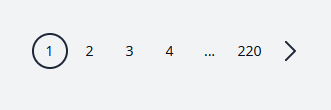

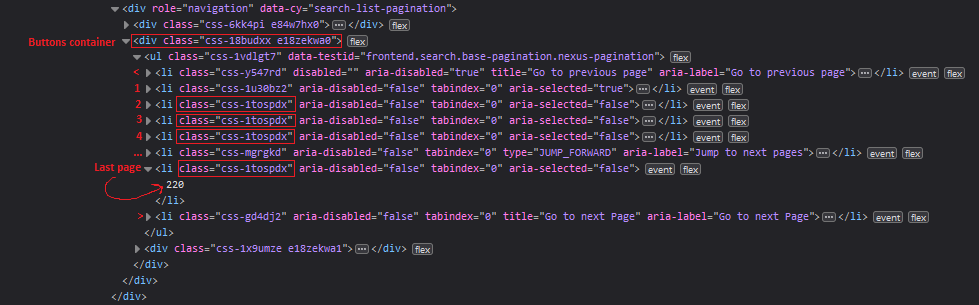

In [555]:
# Function to retrieve the total number of pages for apartment listings
def get_number_of_pages():
    url = 'https://www.storia.ro/ro/rezultate/vanzare/apartament/cluj/cluj--napoca?viewType=listing'
    # To create a request and to parse HTML content
    response = requests.get(url, headers=headers)
    html_content = response.text
    soup = BeautifulSoup(html_content, 'html.parser')
    # To find and retrieve the value of the last button (last page)
    buttons_container = soup.find('div', class_="css-18budxx e18zekwa0")
    page_buttons = buttons_container.find_all('li', class_='css-1tospdx')
    return int(page_buttons[-1].text)

...and another function that retrieves all listing urls from every available page.

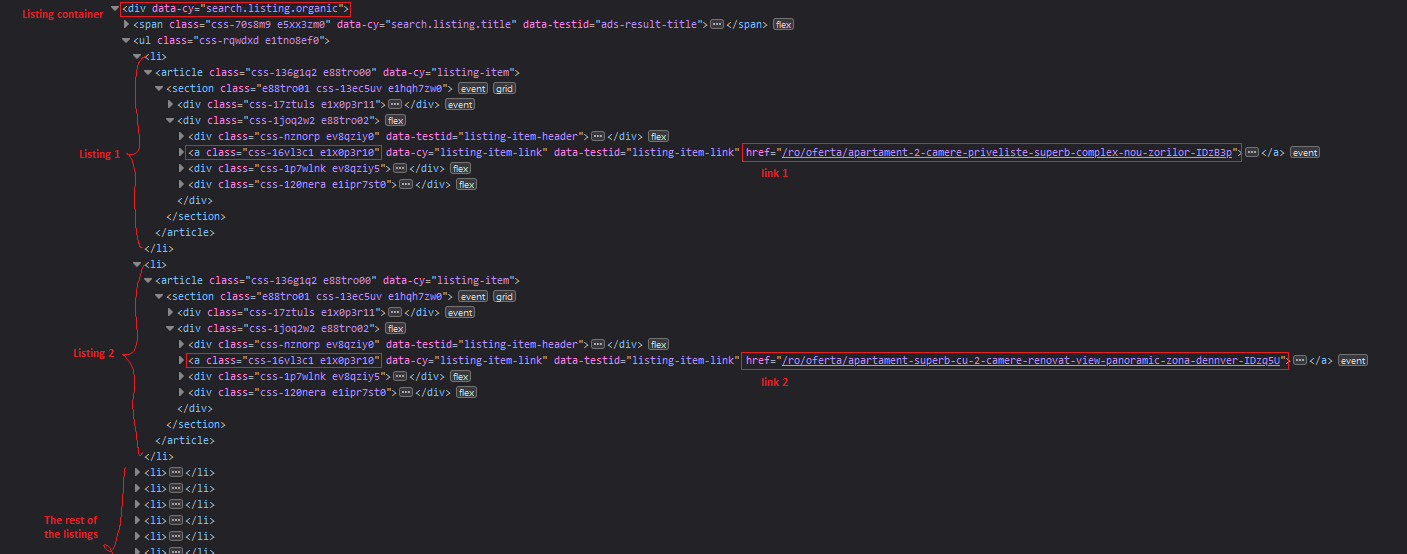

In [558]:
# Function to retrieve apartment listing URLs
def retrieve_listing_urls(pages_to_scrape):
    all_urls = []
    print("Started reading all available pages...")
    print("Pages read: ", end='')
    for page in range(1, pages_to_scrape + 1):
        url = f'https://www.storia.ro/ro/rezultate/vanzare/apartament/cluj/cluj--napoca?viewType=listing&page={page}'
        # To create a request and to parse HTML content
        response = requests.get(url, headers=headers)
        html_content = response.text
        soup = BeautifulSoup(html_content, 'html.parser')
        # To retrieve all listing urls and to convert them to usable format
        try:
            listings_container = soup.find('div', attrs={"data-cy": "search.listing.organic"})
            urls = listings_container.find_all('a', class_='css-16vl3c1 e1x0p3r10')
            for url in urls:
                all_urls.append('https://www.storia.ro' + url['href'])         
        except AttributeError:
            print(f"Warning: Invalid listing at page {page}")  
        # To keep track of current number of pages read    
        if page % 25 == 0:
            print(f"{page}+ ", end='')    
    return all_urls

We are going to retrieve the number of pages and store all listing urls that we found throughout all pages.

In [559]:
total_pages = get_number_of_pages()    
all_listing_urls = retrieve_listing_urls(total_pages)
print("All available listings urls were retrieved!")

# Also, let's see the number of pages and the first few listing urls
print(f"The total amount of pages: {total_pages}")
print ("A preview of a few listing urls:")
print(all_listing_urls[:5])

Started reading all available pages...
Pages read: 25+ 50+ 75+ 100+ 125+ 150+ 175+ 200+ All available listings urls were retrieved!
The total amount of pages: 220
A preview of a few listing urls:
['https://www.storia.ro/ro/oferta/de-vanzare-apartament-mobilat-2-camere-zona-zorilor-145000-eur-IDzCMt', 'https://www.storia.ro/ro/oferta/comision-0-apartament-3-camere-str-nasaud-semicentral-cluj-napo-IDxIDX', 'https://www.storia.ro/ro/oferta/comision-0-apartament-2-camere-str-siretului-chinteni-jud-cluj-IDxeIK', 'https://www.storia.ro/ro/oferta/apartament-de-vanzare-2-camere-gruia-zona-de-case-IDyMNp', 'https://www.storia.ro/ro/oferta/de-la-dezvoltator-apartamente-cu-2-camere-zona-bmw-proiect-nou-IDxWpU']


We will store all the listings urls in a text file.

In [560]:
file_path = 'listing_urls.txt'

with open(file_path, 'w') as file:
    for url in all_listing_urls:
        file.write(url + '\n')
        
print("All urls were saved in listing_urls.txt")
print(f"Total number of apartment listings: {len(all_listing_urls)}")

All urls were saved in listing_urls.txt
Total number of apartment listings: 7888


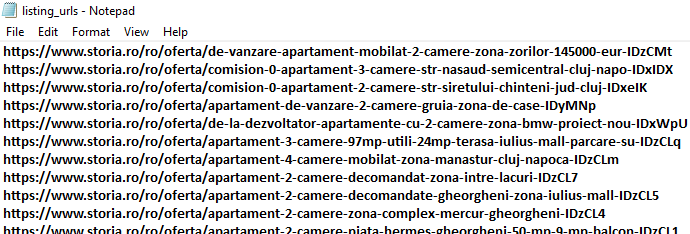

Then, we will create functions that will read all the available details for an apartment listing that are present in the 'details' container.

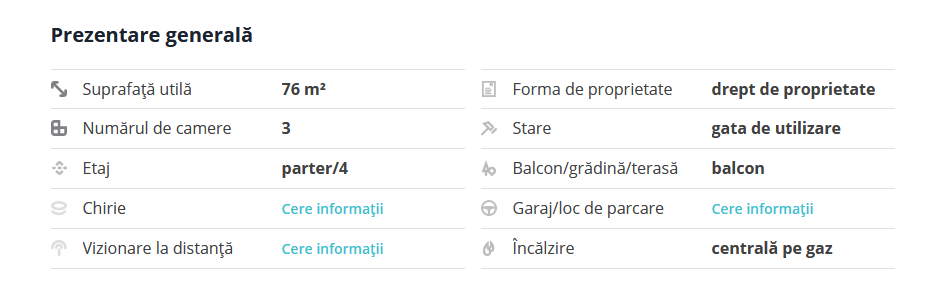

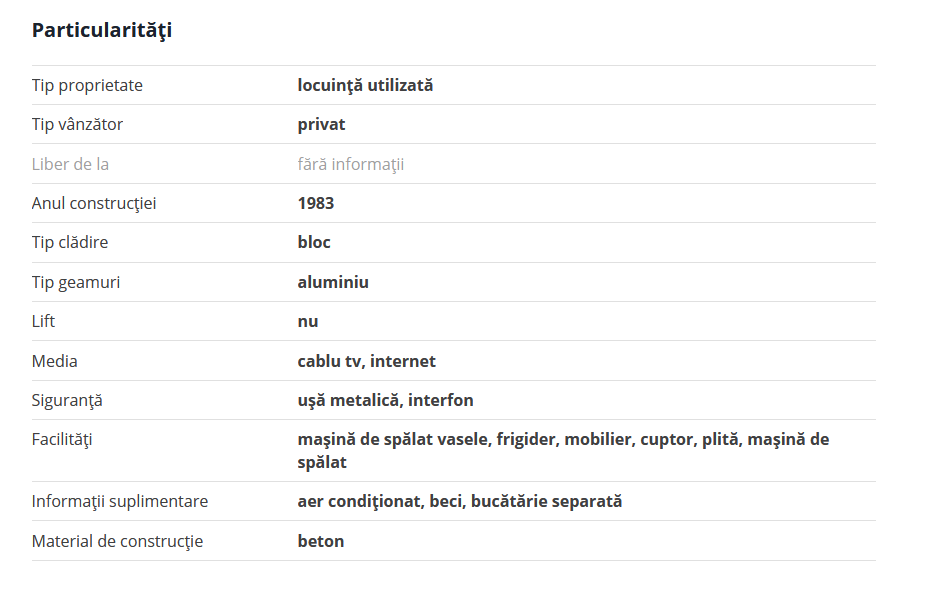

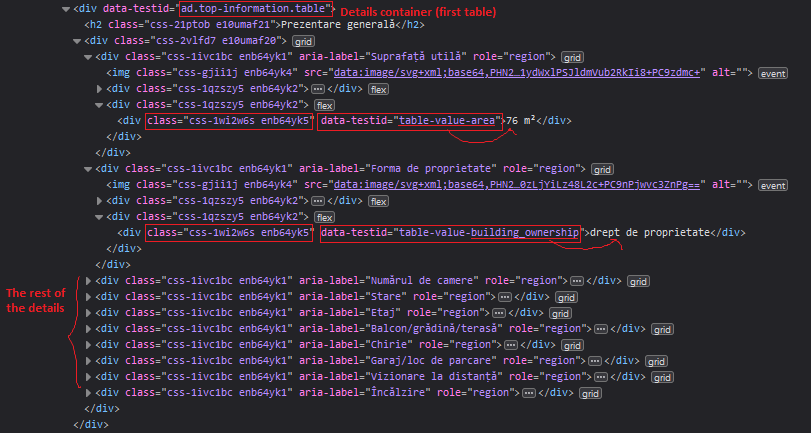

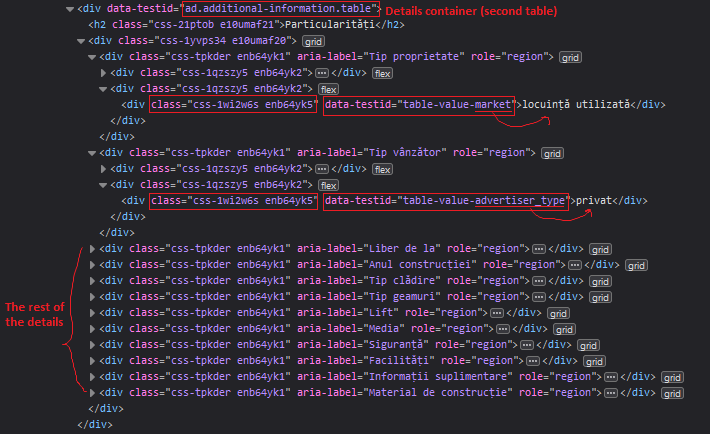

In [561]:
# To retrieve every detail present in 'details information'    
def retrieve_details(data, soup):
    try:
        container = soup.find_all('div', class_='css-1wi2w6s enb64yk5')
        pattern_keys = re.compile(r'table-value-(\w+)')
        for detail in container:
            if 'data-testid' in str(detail):
                key = detail['data-testid']
                key = pattern_keys.search(key).group(1)
                value = detail.get_text(strip=True)
                data.update({key: value})
    except ValueError:
        print("Invalid url", end=', ')

Also, we will create functions that will retrieve details that are not present in the 'details' container, but are situated in the header.

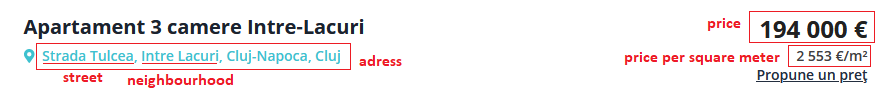

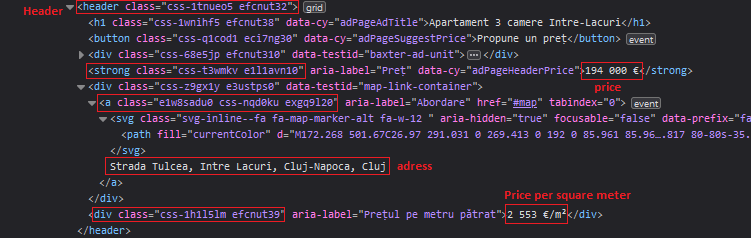

In [562]:
# To retrieve adress information
def retrieve_adress(data, soup):
    try: 
        adress = soup.find('a', class_='e1w8sadu0 css-nqd0ku exgq9l20')
        adress = adress.text
        data.update({'adress': adress})
    except AttributeError:
        print("Adress not found", end=', ')    
        
# To retrieve price information
def retrieve_price(data, soup):
    try:
        price = soup.find('strong', class_='css-t3wmkv e1l1avn10')
        price = price.text
        data.update({'price': price})
    except AttributeError:
        print("Price not found", end=', ')
    
# To retrieve price per square meter information    
def retrieve_price_per_square_meter(data, soup):
    try:
        value = soup.find('div', class_='css-1h1l5lm efcnut39')
        value = value.text
        data.update({'price_per_square_meter': value})
    except AttributeError:
        print("Price per square meter not found", end=', ')

Now, we will create a function that will read all those details into a dictionary (representing an apartment listing). Afterwards, another function that will read all the available details for every apartment listing.

In [568]:
#============= Functions that retrieve and combine all data from every listing ================= 
    
# Retrieves detail information for an apartment listing
def retrieve_listing_details(url):
    resp = requests.get(url, headers=headers)
    html_content = resp.text
    soup = BeautifulSoup(html_content, 'html.parser')
    
    data = dict()
    # To retrieve every detail present in 'details information'
    retrieve_details(data, soup)
    # To retrieve adress information (from header)
    retrieve_adress(data, soup)
    # To retrieve price information (from header)
    retrieve_price(data, soup)
    # To retrieve price per square meter information (from header)
    retrieve_price_per_square_meter(data, soup)
    return data    
    
# Retrieves all the details for every apartment listing.
def get_all_listings_details(urls):
    all_listings = []
    count = 1
    for url in urls:
        count += 1
        details = retrieve_listing_details(url);
        all_listings.append(details)
        # Displays current progress
        if count % 25 == 0:
            print(f"{count}+ ", end='')
        if count == 300:
            break
    return all_listings    

Let's retrieve every detail for all the available apartment listings.

In [569]:
print("Listings read: ", end='')
data = get_all_listings_details(all_listing_urls)
print("All available listings were read!")

Listings read: 25+ 50+ 75+ 100+ 125+ 150+ 175+ 200+ 225+ 250+ 275+ 300+ All available listings were read!


### 1.2 Creating the data frame <a id='creating-data-frame'></a>

Now, we have our data represented as a list of dictionaries, where every dictionary represents an apartment listing, the keys represent the detail name and the values represent the detail value.

Next, we are going to retrieve all unique keys present in our data, so we can create a DataFrame for all listings.

In [570]:
# All unique keys
all_keys = list(set(key for d in data for key in d.keys()))
all_keys = sorted(all_keys)
print(all_keys)

# To create a DataFrame with column labels equal to our unique keys
df = pd.DataFrame(columns=all_keys)

# To add every single listing into our DataFrame
df = pd.DataFrame([listing for listing in data])
print("DataFrame created successfully.")

['adress', 'advertiser_type', 'area', 'build_year', 'building_material', 'building_ownership', 'building_type', 'car', 'construction_status', 'equipment_types', 'extras_types', 'floor', 'heating', 'lift', 'market', 'media_types', 'outdoor', 'price', 'price_per_square_meter', 'rent', 'rooms_num', 'security_types', 'windows_type']
DataFrame created successfully.


Our DataFrame was created. We will save the uncleaned DataFrame into a txt file.

In [571]:
df.to_csv('uncleaned_data.txt', sep=',', index=False)
print("DataFrame saved to 'uncleaned_data.txt'.")

DataFrame saved to 'uncleaned_data.txt'.


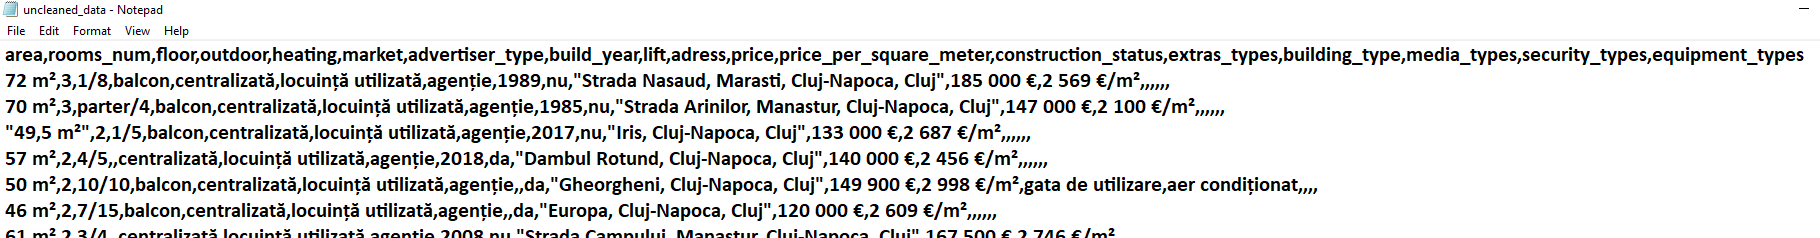

Our DataFrame was created. We can check important information about our data

In [572]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   area                    299 non-null    object
 1   rooms_num               299 non-null    object
 2   floor                   297 non-null    object
 3   outdoor                 113 non-null    object
 4   heating                 124 non-null    object
 5   market                  299 non-null    object
 6   advertiser_type         299 non-null    object
 7   building_type           40 non-null     object
 8   windows_type            32 non-null     object
 9   lift                    299 non-null    object
 10  media_types             34 non-null     object
 11  security_types          41 non-null     object
 12  equipment_types         34 non-null     object
 13  extras_types            45 non-null     object
 14  building_material       29 non-null     object
 15  adress

## 2. Cleaning and Parsing the Data <a id='2'></a>

### 2.1 Checking/Parsing/Modifying every column <a id='2.1'></a>

We will go through each column and decide if it contains important data, if not, we can delete the column. 

We will check if the column needs any parsing. For example, column 'area' can be converted from format <area m²> to < area > (float). Also, column 'price' can be converted from format <price €> to < price > (float).

In [573]:
sorted(df.columns)

['adress',
 'advertiser_type',
 'area',
 'build_year',
 'building_material',
 'building_ownership',
 'building_type',
 'car',
 'construction_status',
 'equipment_types',
 'extras_types',
 'floor',
 'heating',
 'lift',
 'market',
 'media_types',
 'outdoor',
 'price',
 'price_per_square_meter',
 'rent',
 'rooms_num',
 'security_types',
 'windows_type']

Checking/Parsing/Modifying column 'adress'

In [574]:
df['adress'].unique()[:5]

array(['Zorilor, Cluj-Napoca, Cluj',
       'Strada Nasaud, Marasti, Cluj-Napoca, Cluj',
       'Strada Valea Chintaului, Chinteni, Chinteni, Cluj',
       'Gruia, Cluj-Napoca, Cluj', 'Strada Avram Iancu, Floresti, Cluj'],
      dtype=object)

In [575]:
# We can split the adress into two individual columns: street and neighbourhood

def retrieve_street(address):
    try:
        address = [part.strip() for part in address.split(',')]
        if len(address) == 4 and (address[2] == 'Cluj-Napoca'):
            return address[0]
    except Exception as e:
        print(f"Error in retrieve_street: {e}")
    return None

def retrieve_neighbourhood(address):
    try:
        address = [part.strip() for part in address.split(',')]
        if len(address) == 3 and (address[1] == 'Cluj-Napoca'):
            return address[0]
        elif len(address) == 4 and (address[2] == 'Cluj-Napoca'):
            return address[1]
    except Exception as e:
        print(f"Error in retrieve_neighbourhood: {e}")
    return None

    
# To create two new columns: street and neighbourhood    
df['street'] = df['adress'].apply(retrieve_street)
df['neighbourhood'] = df['adress'].apply(retrieve_neighbourhood)    
    
# To delete the adress column    
df = df.drop('adress', axis=1)   

In [576]:
print(df['street'].unique()[:5])
print(df['neighbourhood'].unique()[:5])

[None 'Strada Nasaud' 'Strada Slanic' 'Strada Arinilor' 'Strada Campului']
['Zorilor' 'Marasti' None 'Gruia' 'Gheorgheni']


Checking/Parsing/Modifying column 'advertiser_type'

In [577]:
df['advertiser_type'].unique()
# This column doesn't require any modification

array(['agenție', 'privat'], dtype=object)

Checking/Parsing/Modifying column 'area'

In [578]:
df['area'].unique()[:10]

array(['53 m²', '76,53 m²', '40 m²', '38 m²', '46 m²', '97 m²', '52 m²',
       '51 m²', '43 m²', '50 m²'], dtype=object)

In [579]:
# We will create a function that will parse our 'area' values

def convert_area_values(area):
    if type(area) == str:
        area = area.replace(',', '.')
        return int(float(area.replace(' m²', '').replace(' ', '')))
    else:
        return area

df['area'] = df['area'].apply(convert_area_values)
df['area'] = df['area'].fillna(0).astype(int)
df['area'].unique()[:10]

array([53, 76, 40, 38, 46, 97, 52, 51, 43, 50])

Checking/Parsing/Modifying column 'build_year'

In [580]:
df['build_year'].unique()[:6]

array([nan, '1985', '2010', '1972', '2023', '2015'], dtype=object)

In [581]:
# We need to convert the values from string to int
df['build_year'] = pd.to_numeric(df['build_year'], errors='coerce', downcast='integer')
df['build_year'] = df['build_year'].fillna(0).astype(int)

df['build_year'].unique()

array([   0, 1985, 2010, 1972, 2023, 2015, 2005, 1989, 2017, 2018, 2008,
       2019, 1978, 1986, 1977, 1980, 1997, 1990, 1973, 2016, 1970, 1979,
       1975, 2020, 1983, 1966, 2009, 2021, 2006, 2012, 2022, 2007, 2004,
       2014, 1976, 2000, 1945, 1962, 2002, 1981, 1940, 1950])

In [582]:
# Also, we see that we have values that are absurdly low, therefore, we will negate them
df['build_year'] = df['build_year'].apply(lambda x: 0 if x < 1900 else x)

Checking/Parsing/Modifying column 'building_material'

In [583]:
df['building_material'].unique()
# This column doesn't require any modification

array(['beton', nan, 'cărămidă'], dtype=object)

Checking/Parsing/Modifying column 'building_ownership'

In [584]:
df['building_ownership'].unique()
# This column doesn't require any modification

array([nan, 'drept de proprietate'], dtype=object)

Checking/Parsing/Modifying column 'building_type'

In [585]:
df['building_type'].unique()
# This column doesn't require any modification

array(['bloc', nan, 'clădire de apartamente'], dtype=object)

Checking/Parsing/Modifying column 'car'

In [586]:
df['car'].unique()

array([nan, 'garaj'], dtype=object)

In [587]:
# We can change the name into something more descriptive
df.rename(columns={'car': 'has_parking'}, inplace=True)

Checking/Parsing/Modifying column 'construction_status'

In [588]:
df['construction_status'].unique()
# This column doesn't require any modification

array([nan, 'gata de utilizare', 'în construcție', 'necesita renovare'],
      dtype=object)

Checking/Parsing/Modifying column 'equipment_types'

In [589]:
df['equipment_types'].unique()[:5]

array(['mașină de spălat vasele, frigider, mobilier, cuptor, plită, TV, mașină de spălat',
       nan, 'frigider, mobilier, cuptor, plită, TV, mașină de spălat',
       'frigider, mobilier, cuptor, plită, mașină de spălat',
       'mobilier, cuptor, frigider, mașină de spălat, mașină de spălat vasele'],
      dtype=object)

In [590]:
# We will create a function that will transform the string values into a tuple of string
# Example: 'frigider, mobilier, cuptor' -> ('frigider', 'mobilier', 'cuptor')

# We will create a generic string_to_array_of_string() in case other columns require the same parsing
def string_to_tuple_of_strings(string):
    if (type(string) == str):
        return tuple(x.strip() for x in str(string).split(','))
    else:
        return string
    
df['equipment_types'] = df['equipment_types'].apply(string_to_tuple_of_strings)
df['equipment_types'].unique()[:5]

array([('mașină de spălat vasele', 'frigider', 'mobilier', 'cuptor', 'plită', 'TV', 'mașină de spălat'),
       nan,
       ('frigider', 'mobilier', 'cuptor', 'plită', 'TV', 'mașină de spălat'),
       ('frigider', 'mobilier', 'cuptor', 'plită', 'mașină de spălat'),
       ('mobilier', 'cuptor', 'frigider', 'mașină de spălat', 'mașină de spălat vasele')],
      dtype=object)

Checking/Parsing/Modifying column 'extras_types'

In [591]:
df['extras_types'].unique()[:5]

array(['bucătărie separată, debara', 'aer condiționat', nan,
       'bucătărie separată', 'debara'], dtype=object)

In [592]:
# We will apply the same 'string_to_tuple_of_strings' function to this column
df['extras_types'] = df['extras_types'].apply(string_to_tuple_of_strings)
df['extras_types'].unique()[:5]

array([('bucătărie separată', 'debara'), ('aer condiționat',), nan,
       ('bucătărie separată',), ('debara',)], dtype=object)

Checking/Parsing/Modifying column 'floor'

In [593]:
df['floor'].unique()

array(['4/4', '8/8', 'parter/4', '5/11', '6/10', '10', '8/10', '10/10',
       '1/8', '1/5', '4/5', '7/15', '3/4', '5/6', '2/6', '5/5', '3/8',
       'parter', '1', '1/4', '4', '2/4', '1/1', '4/6', nan, '3', '3/10',
       '3/6', '2/9', '7/8', '8', 'demisol/4', '1/3', '2', '6/12',
       'parter/3', '9/10', '3/3', '5/10', '1/7', '9', '1/14', '6/7',
       '6/6', 'parter/10', 'parter/1', '7/10', '5/8', '7/14', '3/5',
       '2/8', '2/3', '9/11', '2/2', '5/7', '4/14', 'parter/7',
       'demisol/2', '> 10/23', '1/2', 'parter/5', 'demisol/3', '9/13',
       '6', '5/9', '2/10', '3/9', '10/11', '1/10', '7'], dtype=object)

In [594]:
# For better readability, we will write every value in the format 'x/x'

# If the total amount of floors is not specified, we will write floor/x   EX: 3  ->  3/x
# If the floor is 'mansarda', we will write 'x/x'   EX:  mansarda  ->  x/x
#                                                   EX:   mansarda/7  ->  7/7
# If the floor is 'parter', we will write '0/x'    EX:  parter/7  ->  0/7
# If the floor is 'demisol', we will write '-1/x'   EX:  demisol/3  ->  -1/3

def modify_floor_values(floor):
    if pd.isna(floor):
        return floor
    
    value = floor.split('/')
    if value[0][:2] == '> ':
        value[0] = value[0][2:]

    if value[0] == 'mansardă':
        if len(value) == 1:
            return 'x/x'
        else:
            return value[1] + '/' + value[1]

    if value[0] == 'parter':
        if len(value) == 1:
            return '0/x'
        else:
            return '0/' + value[1]

    if value[0] == 'demisol':
        if len(value) == 1:
            return '-1/x'
        else:
            return '-1/' + value[1]

    if len(value) == 1:
        return value[0] + '/x'
    
    return value[0] + '/' + value[1]

df['floor'] = df['floor'].apply(modify_floor_values)
df['floor'].unique()

array(['4/4', '8/8', '0/4', '5/11', '6/10', '10/x', '8/10', '10/10',
       '1/8', '1/5', '4/5', '7/15', '3/4', '5/6', '2/6', '5/5', '3/8',
       '0/x', '1/x', '1/4', '4/x', '2/4', '1/1', '4/6', nan, '3/x',
       '3/10', '3/6', '2/9', '7/8', '8/x', '-1/4', '1/3', '2/x', '6/12',
       '0/3', '9/10', '3/3', '5/10', '1/7', '9/x', '1/14', '6/7', '6/6',
       '0/10', '0/1', '7/10', '5/8', '7/14', '3/5', '2/8', '2/3', '9/11',
       '2/2', '5/7', '4/14', '0/7', '-1/2', '10/23', '1/2', '0/5', '-1/3',
       '9/13', '6/x', '5/9', '2/10', '3/9', '10/11', '1/10', '7/x'],
      dtype=object)

Checking/Parsing/Modifying column 'heating'

In [595]:
df['heating'].unique()
# This column doesn't require any modification

array(['centrală pe gaz', 'centralizată', nan, 'altul', 'sobă'],
      dtype=object)

Checking/Parsing/Modifying column 'lift'

In [596]:
df['lift'].unique()

array(['nu', 'da'], dtype=object)

In [597]:
# We will convert the values from string to boolean

def convert_to_boolean(value):
    if value == 'da':
        return True
    elif value == 'nu':
        return False
    else:
        return value

df['lift'] = df['lift'].apply(convert_to_boolean)
df['lift'].unique()

array([False,  True])

In [598]:
# We can change the column name to be more descriptive
df.rename(columns={'lift': 'has_elevator'}, inplace=True)

Checking/Parsing/Modifying column 'market'

In [599]:
df['market'].unique()
# This column doesn't require any modification

array(['locuință utilizată', 'locuință nouă'], dtype=object)

In [600]:
# We can change the column name to be more descriptive
df.rename(columns={'market': 'property_type'}, inplace=True)

Checking/Parsing/Modifying column 'media_types'

In [601]:
df['media_types'].unique()

array(['cablu tv, internet, telefon', nan, 'cablu tv, internet',
       'telefon, internet, cablu tv', 'internet', 'cablu tv, telefon'],
      dtype=object)

In [602]:
# We will apply the same 'string_to_tuple_of_strings' function to this column
df['media_types'] = df['media_types'].apply(string_to_tuple_of_strings)
df['media_types'].unique()

array([('cablu tv', 'internet', 'telefon'), nan, ('cablu tv', 'internet'),
       ('telefon', 'internet', 'cablu tv'), ('internet',),
       ('cablu tv', 'telefon')], dtype=object)

Checking/Parsing/Modifying column 'outdoor'

In [603]:
df['outdoor'].unique()

array(['balcon', nan, 'terasă', 'balcon, terasă', 'balcon, grădină',
       'grădină'], dtype=object)

In [604]:
# We will apply the same 'string_to_tuple_of_strings' function to this column
df['outdoor'] = df['outdoor'].apply(string_to_tuple_of_strings)
df['outdoor'].unique()

array([('balcon',), nan, ('terasă',), ('balcon', 'terasă'),
       ('balcon', 'grădină'), ('grădină',)], dtype=object)

Checking/Parsing/Modifying column 'price'

In [605]:
df['price'].unique()[:5]

array(['145 000 €', '180 000 €', '70 000 €', '115 000 €', '91 460 €'],
      dtype=object)

In [606]:
# We need to convert the string to an integer using numpy

def modify_rent_price_values(price):
    if ' €' in str(price):
        return int(price.replace(' €', '').replace(' ', ''))
    return price

df['price'] = df['price'].apply(modify_rent_price_values)
df['price'].unique()[:5]

array([145000, 180000,  70000, 115000,  91460], dtype=int64)

In [607]:
# We can see that we have a few absurdly low values, that are incorrect listing details
# Therefore, we need to remove them, to provide a clear and concise analysis

df = df[df['price'] > 1000]

Checking/Parsing/Modifying column 'price_per_square_meter'

In [608]:
df['price_per_square_meter'].unique()[:5]

array(['2 736 €/m²', '2 352 €/m²', '1 750 €/m²', '3 026 €/m²',
       '1 988 €/m²'], dtype=object)

In [609]:
# We need to convert the string to an integer using numpy
def modify_price_per_square_meter_values(value):
    if ' €/m²' in str(value):
        return int(value.replace(' €/m²', '').replace(' ', ''))

df['price_per_square_meter'] = df['price_per_square_meter'].apply(modify_price_per_square_meter_values)
df['price_per_square_meter'].unique()[:5]

array([2736, 2352, 1750, 3026, 1988], dtype=int64)

Checking/Parsing/Modifying column 'rent'

In [610]:
df['rent'].value_counts()
# We can see that there is only a value entered, plus it doesn't allign with our data

rent
700 €    1
650 €    1
400 €    1
Name: count, dtype: int64

In [611]:
# Therefore, we need to delete this column
df = df.drop('rent', axis=1)

Checking/Parsing/Modifying column 'rooms_num'

In [612]:
df['rooms_num'].unique()

array(['2', '3', '4', '1', '5'], dtype=object)

In [613]:
# We need to convert the values from string to int
df['rooms_num'] = df['rooms_num'].astype(int)

df['rooms_num'].unique()

array([2, 3, 4, 1, 5])

Checking/Parsing/Modifying column 'security_types'

In [614]:
df['security_types'].unique()

array(['ușă metalică, interfon', nan,
       'alarmă, ușă metalică, interfon, supraveghere video',
       'interfon, ușă metalică', 'ușă metalică', 'interfon',
       'ușă metalică, curte, interfon', 'alarmă, supraveghere video',
       'interfon, obloane', 'alarmă',
       'ușă metalică, interfon, supraveghere video'], dtype=object)

In [615]:
# Same as before, we will convert a string to a tumple of strings

df['security_types'] = df['security_types'].apply(string_to_tuple_of_strings)
df['security_types'].unique()

array([('ușă metalică', 'interfon'), nan,
       ('alarmă', 'ușă metalică', 'interfon', 'supraveghere video'),
       ('interfon', 'ușă metalică'), ('ușă metalică',), ('interfon',),
       ('ușă metalică', 'curte', 'interfon'),
       ('alarmă', 'supraveghere video'), ('interfon', 'obloane'),
       ('alarmă',), ('ușă metalică', 'interfon', 'supraveghere video')],
      dtype=object)

Checking/Parsing/Modifying column 'windows_type'

In [616]:
df['windows_type'].unique()
# This column doesn't require any modification

array(['plastic', nan, 'aluminiu', 'lemn'], dtype=object)

### 2.2 Removing listing duplicates <a id='2.2'></a>

Some apartments are listed multiple times by different agencies, therefore, we need to remove them from our dataframe.

In [617]:
old_size = df.shape[0]
duplicates = df.duplicated(subset=['area', 'rooms_num', 'floor', 'build_year', 'neighbourhood'], keep='first')
df = df[~duplicates]
print(f"Duplicates removed! Number of duplicates found: {old_size - df.shape[0]}")

Duplicates removed! Number of duplicates found: 4


### 2.3 Saving data <a id='2.3'></a>

**Finally**, our data is clean and concise, therefore, we can save our data into another file, 'clean_data.txt'

In [618]:
df.to_csv('cleaned_data.txt', sep=',', index=False)
print("Data saves in cleaned_data.txt")

Data saves in cleaned_data.txt


Let's see the first few entries in our data 

In [619]:
df.head(10)

,area,rooms_num,floor,outdoor,heating,property_type,advertiser_type,building_type,windows_type,has_elevator,...,extras_types,building_material,price,price_per_square_meter,construction_status,build_year,building_ownership,has_parking,street,neighbourhood
0,53,2,4/4,"(balcon,)",centrală pe gaz,locuință utilizată,agenție,bloc,plastic,False,...,"(bucătărie separată, debara)",beton,145000,2736,NaN,0,NaN,NaN,None,Zorilor
1,76,3,8/8,"(balcon,)",centralizată,locuință nouă,agenție,NaN,NaN,True,...,"(aer condiționat,)",NaN,180000,2352,gata de utilizare,1985,NaN,NaN,Strada Nasaud,Marasti
2,40,2,0/4,"(balcon,)",centralizată,locuință nouă,agenție,NaN,NaN,False,...,NaN,NaN,70000,1750,gata de utilizare,2010,NaN,NaN,None,None
3,38,2,4/4,"(balcon,)",centralizată,locuință nouă,agenție,NaN,NaN,False,...,NaN,NaN,115000,3026,gata de utilizare,1972,NaN,NaN,None,Gruia
4,46,2,5/11,"(balcon,)",centrală pe gaz,locuință nouă,agenție,bloc,plastic,True,...,NaN,cărămidă,91460,1988,în construcție,2023,drept de proprietate,garaj,None,None
5,97,3,6/10,"(balcon,)",NaN,locuință nouă,agenție,NaN,NaN,False,...,NaN,NaN,389000,4010,gata de utilizare,2015,NaN,NaN,Strada Slanic,Gheorgheni
6,53,4,4/4,NaN,centralizată,locuință nouă,agenție,NaN,NaN,False,...,NaN,NaN,110000,2075,gata de utilizare,0,NaN,NaN,None,Manastur
7,52,2,4/4,"(balcon,)",centralizată,locuință nouă,agenție,NaN,NaN,False,...,NaN,NaN,130000,2500,NaN,2005,NaN,NaN,None,Intre Lacuri
8,51,2,10/x,"(balcon,)",centralizată,locuință nouă,agenție,NaN,NaN,False,...,NaN,NaN,130000,2549,necesita renovare,0,NaN,NaN,None,Gheorgheni
9,43,2,8/10,"(balcon,)",centralizată,locuință nouă,agenție,NaN,NaN,True,...,NaN,NaN,135000,3140,NaN,0,NaN,NaN,None,Gheorgheni


## 3. Statistical Analysis (NumPy) <a id='3'></a>

We are going to showcase a few statistics for numerical columns using **numpy** library

Area analysis

In [620]:
mean_area = np.mean(df['area'])
print(f"Average apartment surface area is: {int(mean_area)} m²")
median_area = np.median(df['area'])
print(f"Median apartment surface area is: {int(median_area)} m²")

min_area = np.min(df['area'])
print(f"The smallest surface area of an apartment is: {min_area} m²")
max_area = np.max(df['area'])
print(f"The biggest surface area of an apartment is: {max_area} m²")

Average apartment surface area is: 57 m²
Median apartment surface area is: 54 m²
The smallest surface area of an apartment is: 11 m²
The biggest surface area of an apartment is: 200 m²


Price Analysis

In [621]:
# Price Analysis
mean_price = np.mean(df['price'])
print(f"Average apartment price is: {int(mean_price)} €")
median_price = np.median(df['price'])
print(f"Median apartment price is: {int(median_price)} €")

min_price = np.min(df['price'])
print(f"The lowest price for an apartment is: {min_price} €")
max_price = np.max(df['price'])
print(f"The highest price for an apartment is: {max_price} €")

Average apartment price is: 156498 €
Median apartment price is: 140000 €
The lowest price for an apartment is: 30500 €
The highest price for an apartment is: 550000 €


Number of rooms per apartment Analysis

In [622]:
mean_room = np.mean(df['rooms_num'])
print(f"Average amount of rooms in an apartment is: {round(mean_room, 3)}")
median_room = np.median(df['rooms_num'])
print(f"Median amount of rooms in an apartment is: {round(median_room, 3)}")

Average amount of rooms in an apartment is: 2.323
Median amount of rooms in an apartment is: 2.0


Build year Analysis

In [623]:
filtered_df = df[df['build_year'] != 0]

mean_build_year = np.nanmean(filtered_df['build_year'])
print(f"Average apartment building year is: {int(mean_build_year)}")
median_build_year = np.nanmedian(filtered_df['build_year'])
print(f"Median apartment building year is: {int(median_build_year)}")

old_build_year = np.min(filtered_df['build_year'])
print(f"The oldest building was built in year: {int(old_build_year)}")
new_build_year = np.max(filtered_df['build_year'])
print(f"The newest building was built/will be built in year: {int(new_build_year)}")

Average apartment building year is: 1999
Median apartment building year is: 2006
The oldest building was built in year: 1940
The newest building was built/will be built in year: 2023


Let's find out what is the average price per meter square. <a id='average_price_per_meter_calc'></a>

In [624]:
average_price_per_square_meter = int(np.mean(df['price_per_square_meter']))
print(f"Average price per square meter is {average_price_per_square_meter} €")

Average price per square meter is 2752 €


We will retrieve the average price per square meter for the most popular 7 neighbourhoods. <a id='popular_neighbourhoods_calc'></a>

In [625]:
# Retrieve average price per square meter in a specified neighbourhood
def neighbourhood_price_per_meter_square(neighbourhood):
    temp_df = df[df['neighbourhood'] == neighbourhood]
    return int(np.mean(temp_df['price_per_square_meter']))
    
# Most popular 7 neighbourhoods    
neighbourhoods = df['neighbourhood'].value_counts().head(7)

for neigh in neighbourhoods.index:
    print(f"Average price per square meter in {neigh} is {neighbourhood_price_per_meter_square(neigh)}")

Average price per square meter in Marasti is 2715
Average price per square meter in Manastur is 2489
Average price per square meter in Gheorgheni is 2974
Average price per square meter in Centru is 3689
Average price per square meter in Iris is 2401
Average price per square meter in Buna Ziua is 2814
Average price per square meter in Intre Lacuri is 2638


Let's find out what is the average price of an apartment with specific number of rooms <a id='average_price_per_room_calc'></a>

In [626]:
# Average price of an apartment with specified number of rooms
def average_price_for_x_rooms(rooms):
    temp_df = df[df['rooms_num'] == rooms]
    values = temp_df['price']
    return int(np.mean(values))

rooms_nums = sorted(df['rooms_num'].unique())

for room in rooms_nums:
    print(f"Average price for an apartment with {room} rooms is {average_price_for_x_rooms(room)}")

Average price for an apartment with 1 rooms is 83512
Average price for an apartment with 2 rooms is 142172
Average price for an apartment with 3 rooms is 196338
Average price for an apartment with 4 rooms is 219882
Average price for an apartment with 5 rooms is 390000


## 4. Statistical Visualization (Matplotlib) <a id='4'></a>

We can start visualising different statistics and creating various relations between columns to showcase our data

### 4.1 Pie Charts <a id='4.1'></a>

We will start by visualising a few simple pie charts for a few columns using **matplotlib** library.

Columns: 'advertiser_type', 'building_material', 'building_ownership', 'building_type', 'has_parking', 'construction_status', 'heating', 'has_elevator', 'property_type', 'windows_type'

#### advertiser_type Pie Chart

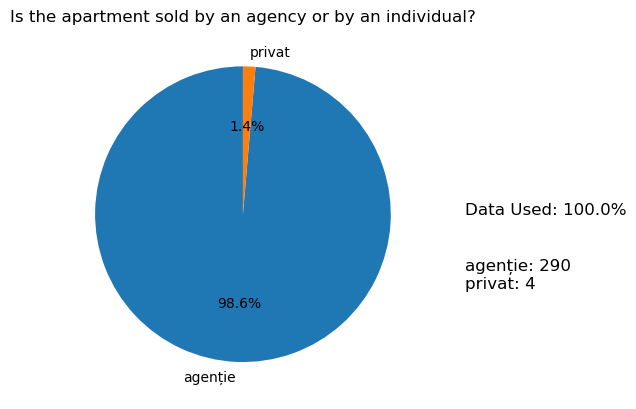

In [627]:
# Data to be analysed
data_used_percentage = (df['advertiser_type'].count() / len(df)) * 100
counts = df['advertiser_type'].value_counts().to_dict()
text_annotation = [f'{key}: {value}' for key, value in counts.items()]
multiline_text = '\n'.join(text_annotation)

# To create a pie chart with additional text info
plt.pie(df['advertiser_type'].value_counts(), labels=df['advertiser_type'].value_counts().index, autopct='%1.1f%%', startangle=90)
plt.title('Is the apartment sold by an agency or by an individual?')
plt.text(1.5, 0, f'Data Used: {data_used_percentage:.1f}%', color='black', fontsize=12)
plt.text(1.5, -0.5, multiline_text, color='black', fontsize=12)
plt.show()

#### building_material Pie Chart

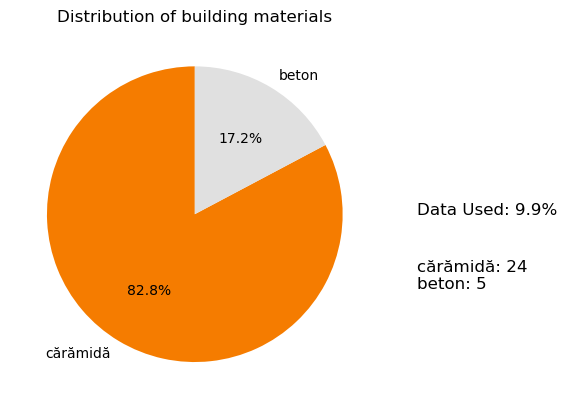

In [628]:
# Data to be analysed
data_used_percentage = (df['building_material'].count() / len(df)) * 100
counts = df['building_material'].value_counts().to_dict()
text_annotation = [f'{key}: {value}' for key, value in counts.items()]
multiline_text = '\n'.join(text_annotation)

# To create a pie chart with additional text info
colors = ['#F57C00', '#E0E0E0', '#BDBDBD', '#9E9E9E']
plt.pie(df['building_material'].value_counts(), labels=df['building_material'].value_counts().index, autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('Distribution of building materials')
plt.text(1.5, 0, f'Data Used: {data_used_percentage:.1f}%', color='black', fontsize=12)
plt.text(1.5, -0.5, multiline_text, color='black', fontsize=12)
plt.show()

#### building_ownership Pie Chart

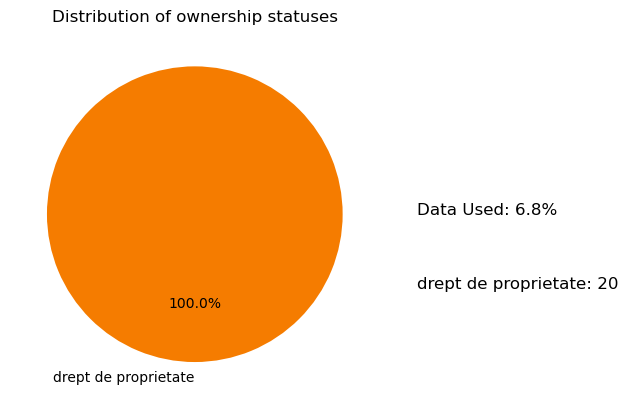

In [629]:
# Data to be analysed
data_used_percentage = (df['building_ownership'].count() / len(df)) * 100
counts = df['building_ownership'].value_counts().to_dict()
text_annotation = [f'{key}: {value}' for key, value in counts.items()]
multiline_text = '\n'.join(text_annotation)

# To create a pie chart with additional text info
plt.pie(df['building_ownership'].value_counts(), labels=df['building_ownership'].value_counts().index, autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('Distribution of ownership statuses')
plt.text(1.5, 0, f'Data Used: {data_used_percentage:.1f}%', color='black', fontsize=12)
plt.text(1.5, -0.5, multiline_text, color='black', fontsize=12)
plt.show()

#### building_type Pie Chart

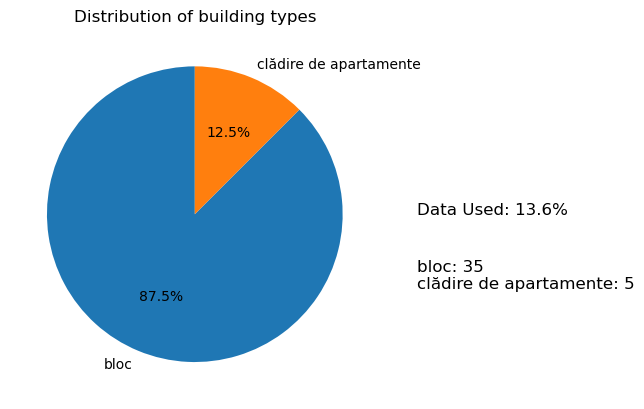

In [630]:
# Data to be analysed
data_used_percentage = (df['building_type'].count() / len(df)) * 100
counts = df['building_type'].value_counts().to_dict()
text_annotation = [f'{key}: {value}' for key, value in counts.items()]
multiline_text = '\n'.join(text_annotation)

# To create a pie chart with additional text info
plt.pie(df['building_type'].value_counts(), labels=df['building_type'].value_counts().index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of building types')
plt.text(1.5, 0, f'Data Used: {data_used_percentage:.1f}%', color='black', fontsize=12)
plt.text(1.5, -0.5, multiline_text, color='black', fontsize=12)
plt.show()

#### has_parking Pie Chart

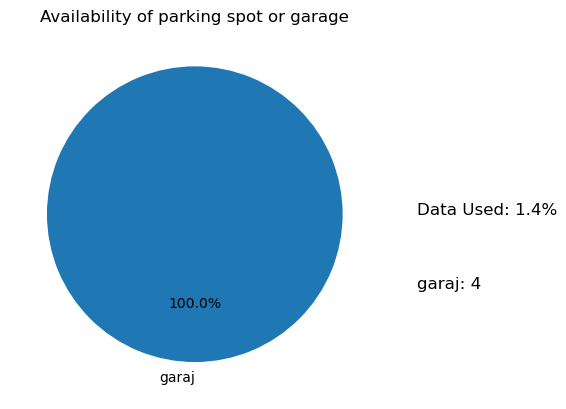

In [631]:
# Data to be analysed
data_used_percentage = (df['has_parking'].count() / len(df)) * 100
counts = df['has_parking'].value_counts().to_dict()
text_annotation = [f'{key}: {value}' for key, value in counts.items()]
multiline_text = '\n'.join(text_annotation)

# To create a pie chart with additional text info
plt.pie(df['has_parking'].value_counts(), labels=df['has_parking'].value_counts().index, autopct='%1.1f%%', startangle=90)
plt.title('Availability of parking spot or garage')
plt.text(1.5, 0, f'Data Used: {data_used_percentage:.1f}%', color='black', fontsize=12)
plt.text(1.5, -0.5, multiline_text, color='black', fontsize=12)
plt.show()

#### construction_status Pie Chart

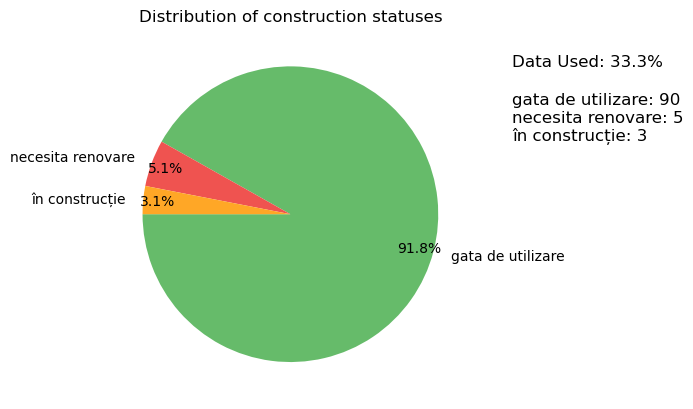

In [632]:
# Data to be analysed
data_used_percentage = (df['construction_status'].count() / len(df)) * 100
counts = df['construction_status'].value_counts().to_dict()
text_annotation = [f'{key}: {value}' for key, value in counts.items()]
multiline_text = '\n'.join(text_annotation)

# To create a pie chart with additional text info
colors = ['#66BB6A', '#EF5350', '#FFA726']
plt.pie(df['construction_status'].value_counts(), labels=df['construction_status'].value_counts().index, autopct='%1.1f%%', startangle=180, colors=colors, pctdistance=0.90, labeldistance=1.12)
plt.title('Distribution of construction statuses')
plt.text(1.5, 1, f'Data Used: {data_used_percentage:.1f}%', color='black', fontsize=12)
plt.text(1.5, 0.5, multiline_text, color='black', fontsize=12)
plt.show()

#### heating Pie Chart

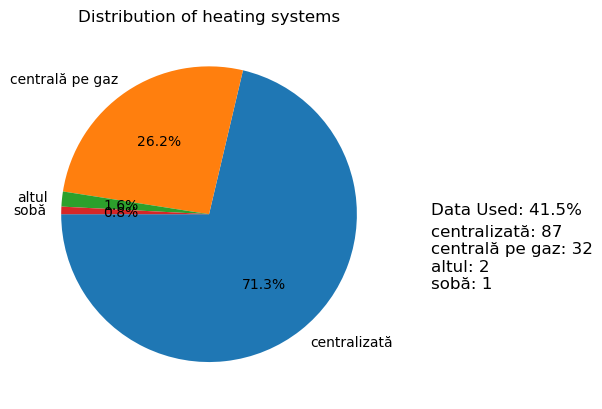

In [633]:
# Data to be analysed
data_used_percentage = (df['heating'].count() / len(df)) * 100
counts = df['heating'].value_counts().to_dict()
text_annotation = [f'{key}: {value}' for key, value in counts.items()]
multiline_text = '\n'.join(text_annotation)

# To create a pie chart with additional text info
plt.pie(df['heating'].value_counts(), labels=df['heating'].value_counts().index, autopct='%1.1f%%', startangle=180)
plt.title('Distribution of heating systems')
plt.text(1.5, 0, f'Data Used: {data_used_percentage:.1f}%', color='black', fontsize=12)
plt.text(1.5, -0.5, multiline_text, color='black', fontsize=12)
plt.show()

#### has_elevator Pie Chart

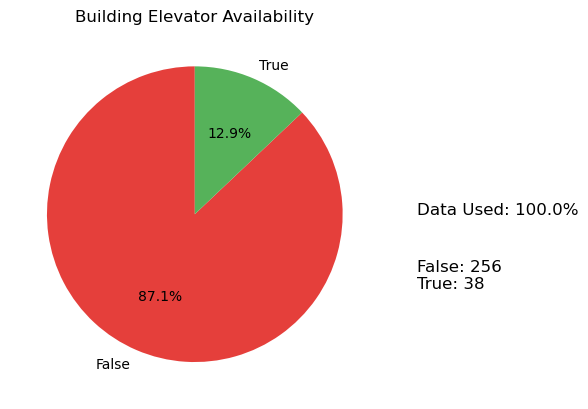

In [634]:
# Data to be analysed
data_used_percentage = (df['has_elevator'].count() / len(df)) * 100
counts = df['has_elevator'].value_counts().to_dict()
text_annotation = [f'{key}: {value}' for key, value in counts.items()]
multiline_text = '\n'.join(text_annotation)

# To create a pie chart with additional text info
colors = ['#E53F3B', '#56B25A']
plt.pie(df['has_elevator'].value_counts(), labels=df['has_elevator'].value_counts().index, autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('Building Elevator Availability')
plt.text(1.5, 0, f'Data Used: {data_used_percentage:.1f}%', color='black', fontsize=12)
plt.text(1.5, -0.5, multiline_text, color='black', fontsize=12)
plt.show()

#### property_type Pie Chart

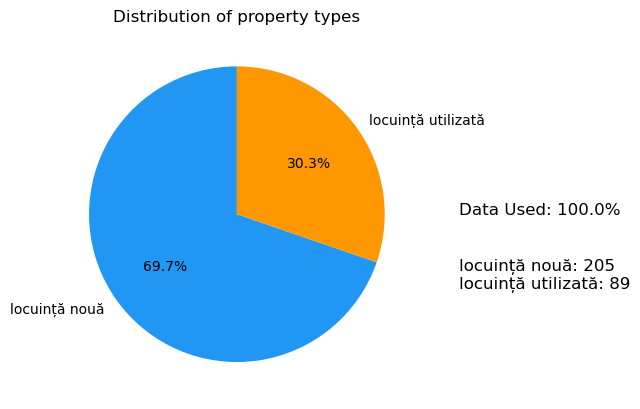

In [635]:
# Data to be analysed
data_used_percentage = (df['property_type'].count() / len(df)) * 100
counts = df['property_type'].value_counts().to_dict()
text_annotation = [f'{key}: {value}' for key, value in counts.items()]
multiline_text = '\n'.join(text_annotation)

# To create a pie chart with additional text info
colors = ['#2196F3', '#FF9800']
plt.pie(df['property_type'].value_counts(), labels=df['property_type'].value_counts().index, autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('Distribution of property types')
plt.text(1.5, 0, f'Data Used: {data_used_percentage:.1f}%', color='black', fontsize=12)
plt.text(1.5, -0.5, multiline_text, color='black', fontsize=12)
plt.show()

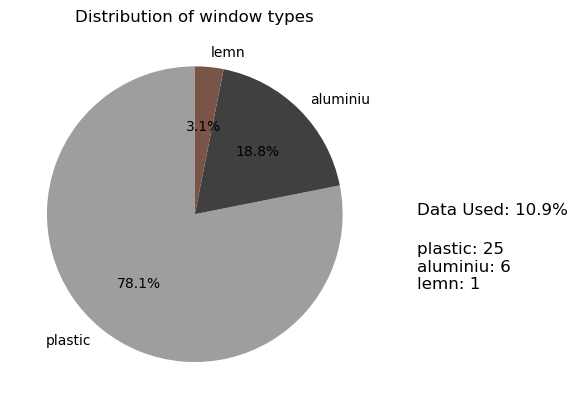

In [636]:
# Data to be analysed
data_used_percentage = (df['windows_type'].count() / len(df)) * 100
counts = df['windows_type'].value_counts().to_dict()
text_annotation = [f'{key}: {value}' for key, value in counts.items()]
multiline_text = '\n'.join(text_annotation)

# To create a pie chart with additional text info
colors = ['#9E9E9E', '#404040', '#795548']
plt.pie(df['windows_type'].value_counts(), labels=df['windows_type'].value_counts().index, autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('Distribution of window types')
plt.text(1.5, 0, f'Data Used: {data_used_percentage:.1f}%', color='black', fontsize=12)
plt.text(1.5, -0.5, multiline_text, color='black', fontsize=12)
plt.show()

### 4.2 Bar Charts and Histrograms<a id='4.2'></a>


Next, we are going to visualize a few columns as bar/histogram charts.

Columns: 'neighbourhood', 'price', 'rooms_num', 'build_year', 'floor'


### neighbourhood Bar Chart <a id='popular_neighbourhoods_visualized'></a>

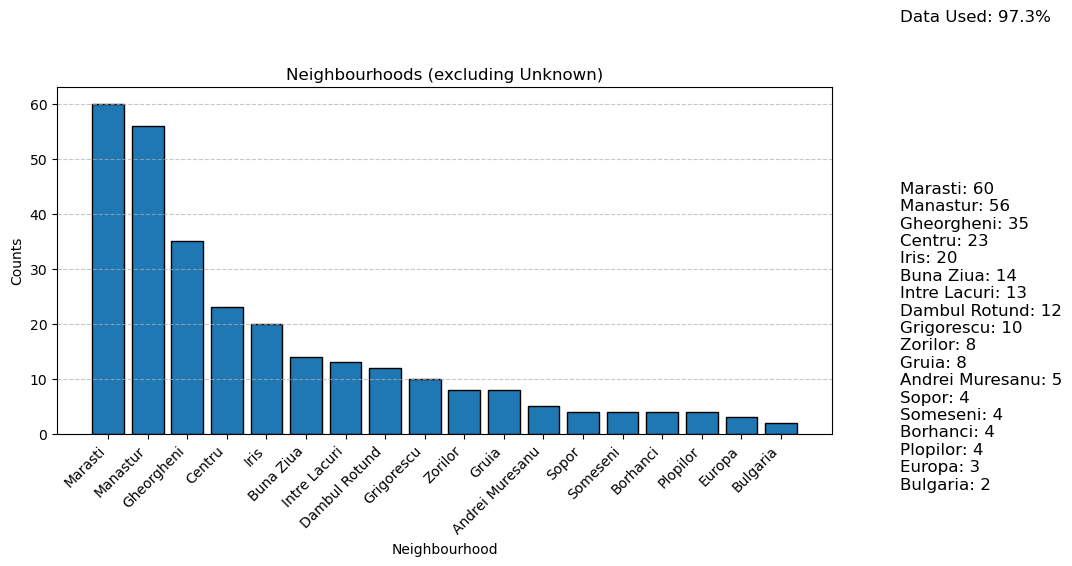

In [637]:
# Filter unknown neighbourhood
df['neighbourhood'] = df['neighbourhood'].fillna('Unknown')
filtered_df = df[df['neighbourhood'] != 'Unknown']

# Data to be analysed
data_used_percentage = (len(filtered_df)) / len(df) * 100
counts = filtered_df['neighbourhood'].value_counts().head(18).to_dict()
text_annotation = [f'{key}: {value}' for key, value in counts.items()]
multiline_text = '\n'.join(text_annotation)

# Create bar for the most popular 18 neighbourhoods
counts = filtered_df['neighbourhood'].value_counts().head(18)
plt.figure(figsize=(10, 4.5))
plt.bar(counts.index, counts, edgecolor='black')
plt.xlabel('Neighbourhood')
plt.ylabel('Counts')
plt.title('Neighbourhoods (excluding Unknown)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.text(20, 75, f'Data Used: {data_used_percentage:.1f}%', color='black', fontsize=12)
plt.text(20, -10, multiline_text, color='black', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.show()

#### price Histogram Chart

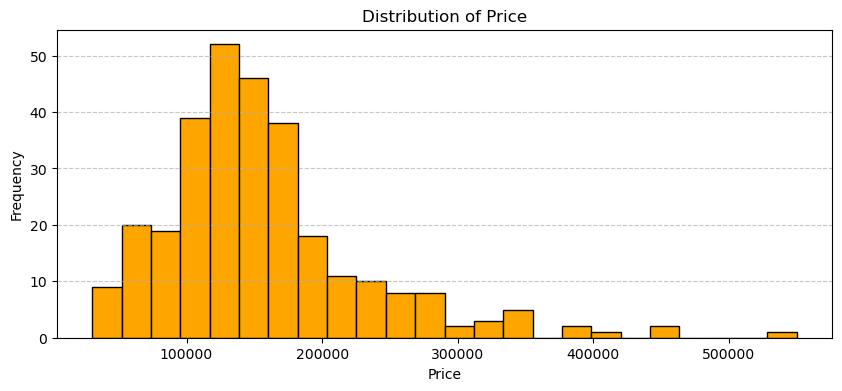

In [638]:
# Create hist chart
plt.figure(figsize=(10, 4))
plt.hist(df['price'], bins = 24, color='orange', edgecolor='black')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Distribution of Price')
plt.show()

#### rooms Bar Chart

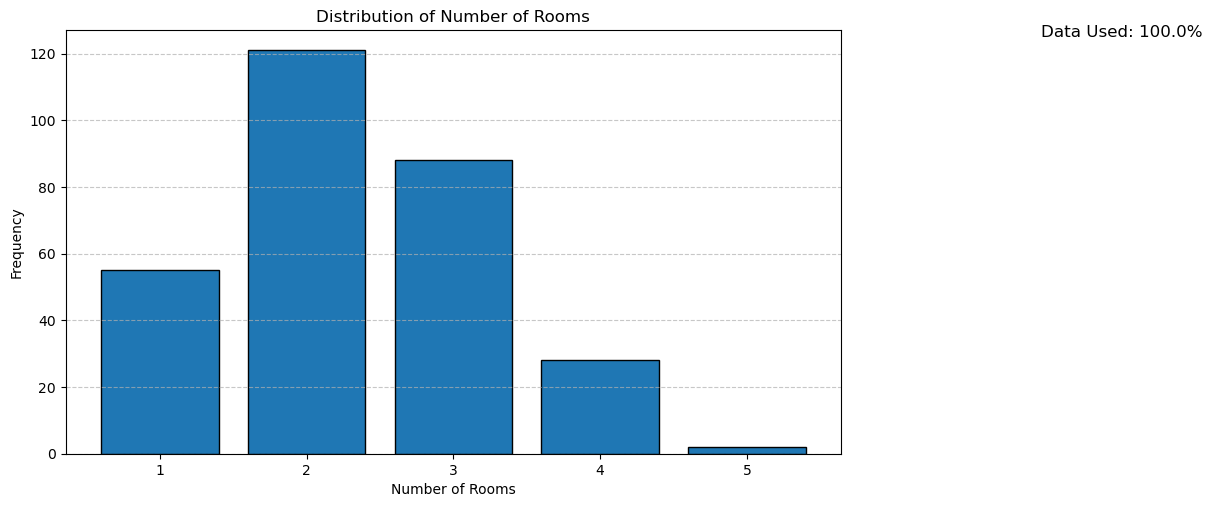

In [639]:
df['rooms_num'] = df['rooms_num'].fillna('Unknown')

# Filter data
filtered_df = df[df['rooms_num'] != 'Unknown']
filtered_df = filtered_df.sort_values(by='rooms_num')

# Data to be analysed
data_used_percentage = (len(filtered_df)) / len(df) * 100
text_annotation = [f'{key}: {value}' for key, value in counts.items()]
multiline_text = '\n'.join(text_annotation)

# Create bar chart
plt.figure(figsize=(10, 5.5))
counts = df['rooms_num'].value_counts()
plt.bar(counts.index, counts, edgecolor='black')
plt.xlabel('Number of Rooms')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.text(7, 125, f'Data Used: {data_used_percentage:.1f}%', color='black', fontsize=12)
plt.title('Distribution of Number of Rooms')
plt.show()

#### build_year Histogram Chart  <a id='build_year_visualized1'></a>

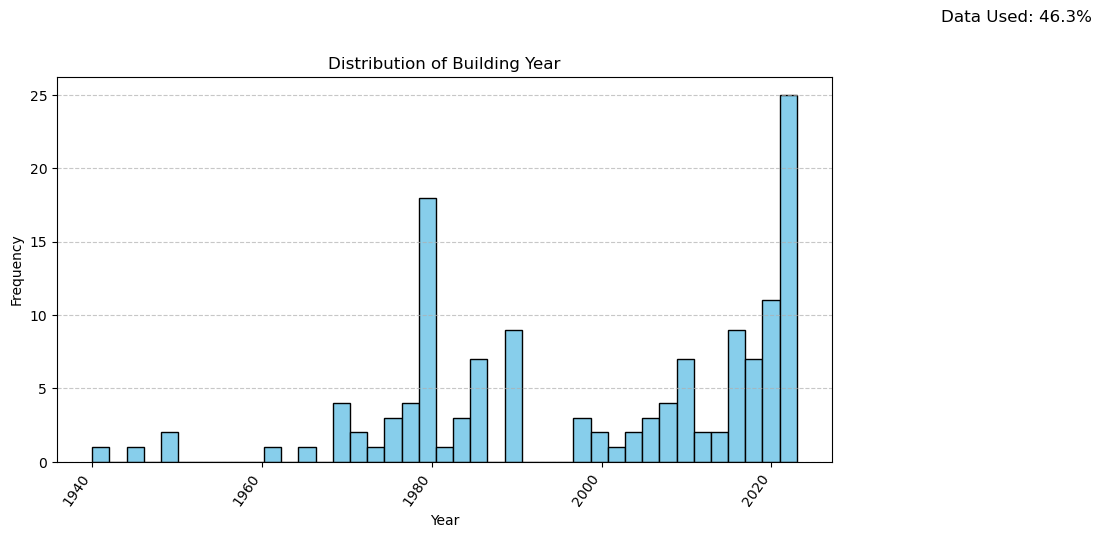

In [640]:
# Filter data
filtered_df = df[df['build_year'] != 0]
filtered_df = filtered_df.sort_values(by='build_year')

# Data to be analysed
data_used_percentage = (len(filtered_df)) / len(df) * 100
text_annotation = [f'{key}: {value}' for key, value in counts.items()]
multiline_text = '\n'.join(text_annotation)

# Create histogram
plt.figure(figsize=(10, 5))
plt.hist(filtered_df['build_year'], bins = filtered_df['build_year'].nunique(), color='skyblue', edgecolor='black')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.text(2040, 30, f'Data Used: {data_used_percentage:.1f}%', color='black', fontsize=12)
plt.title('Distribution of Building Year')
plt.xticks(rotation=55, ha='right')
plt.show()

#### floor Bar Chart

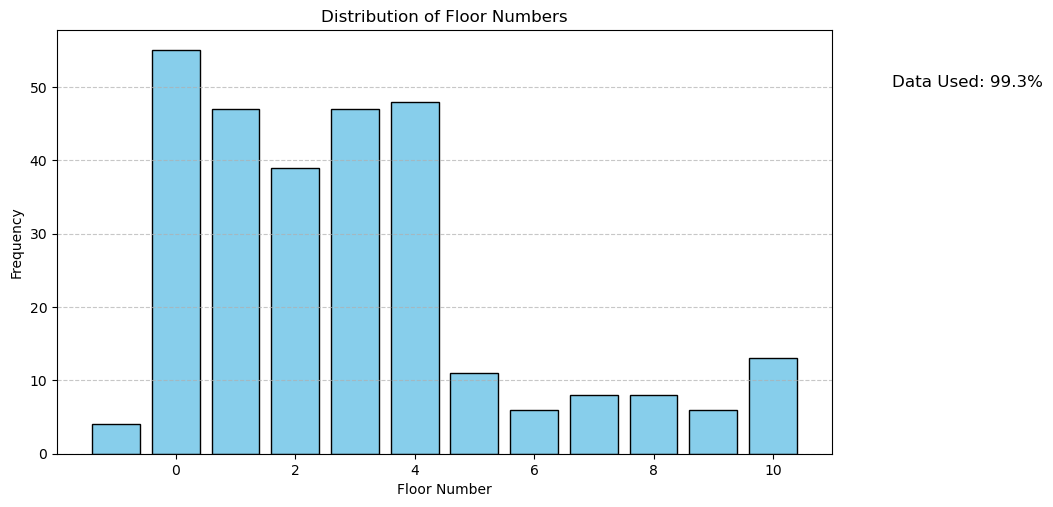

In [641]:
# Parse the data
temp_df = pd.DataFrame()
temp_df['floor_number'] = df['floor'].str.split('/').str[0]

# Convert 'floor_number' to numeric
temp_df['floor_number'] = pd.to_numeric(temp_df['floor_number'], errors='coerce')

# Data to be analyzed
data_used_percentage = (temp_df['floor_number'].count()) / len(df) * 100

# Create a bar chart
plt.figure(figsize=(10, 5.5))
floor_counts = temp_df['floor_number'].value_counts().sort_index()  # Sort by floor numbers
plt.bar(floor_counts.index, floor_counts, color='skyblue', edgecolor='black')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.text(12, 50, f'Data Used: {data_used_percentage:.1f}%', color='black', fontsize=12)
plt.xlabel('Floor Number')
plt.ylabel('Frequency')
plt.title('Distribution of Floor Numbers')
plt.show()

### 4.3 Scatter Plots <a id='4.3'></a>

Next, we are going to combine a few columns as scatter charts.
Columns combined: 'area', 'price', 'building_year', 'rooms_num'

#### *area* & *price* Scatter Chart <a id='average_price_per_meter_vis'></a>

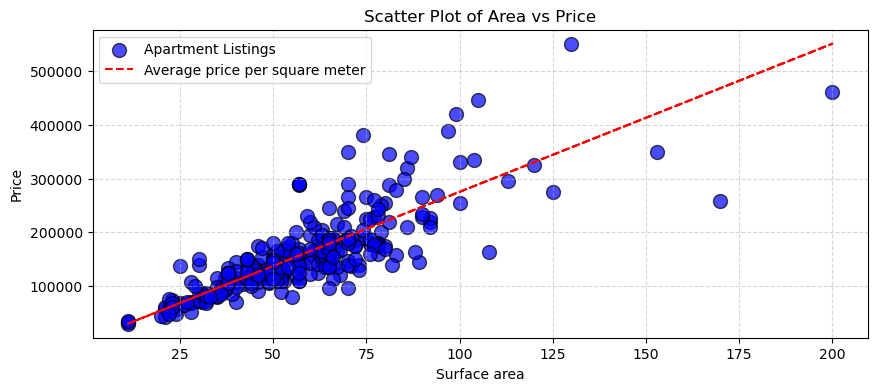

In [642]:
# Create scatter plot
plt.figure(figsize=(10, 4))
plt.scatter(df['area'], df['price'], alpha=0.7, s=100, c='blue', edgecolor='black', label='Apartment Listings')
plt.grid(True, linestyle='--', alpha=0.5)
plt.xlabel('Surface area')
plt.ylabel('Price')
plt.title('Scatter Plot of Area vs Price')

# Remember how we found out the average price per meter square using numpy?
# We will use that variable here to create a diagonal line, showcasing if listings prices are higher or lower than the average 
plt.plot(df['area'], df['area'] * average_price_per_square_meter, color='red', linestyle='--', label='Average price per square meter')

plt.legend()
plt.show()

#### *price* & *rooms_num* Scatter Chart <a id='average_price_per_room_vis'></a>

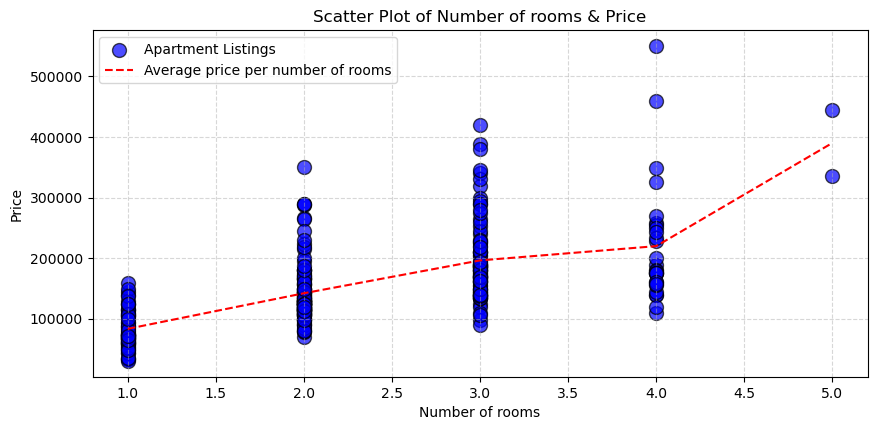

In [643]:
# Create scatter chart
plt.figure(figsize=(10, 4.5))
plt.scatter(df['rooms_num'], df['price'], alpha=0.7, s=100, c='blue', edgecolor='black', label='Apartment Listings')
plt.grid(True, linestyle='--', alpha=0.5)
plt.xlabel('Number of rooms')
plt.ylabel('Price')
plt.title('Scatter Plot of Number of rooms & Price')

# Remember how we used a function to calculate the average price for an apartment with x rooms?
# We will use that function here to showcase if an apartment is higher or lower that the average

# Values that will be used to construct the line
x_values = np.unique(df['rooms_num'])
y_values = [average_price_for_x_rooms(room) for room in x_values]

# To plot the line for average price per room
plt.plot(x_values, y_values, color='red', linestyle='--', label='Average price per number of rooms')

plt.legend()
plt.show()

#### *price* & *rooms_num* Scatter Chart <a id='build_year_visualized2'></a>

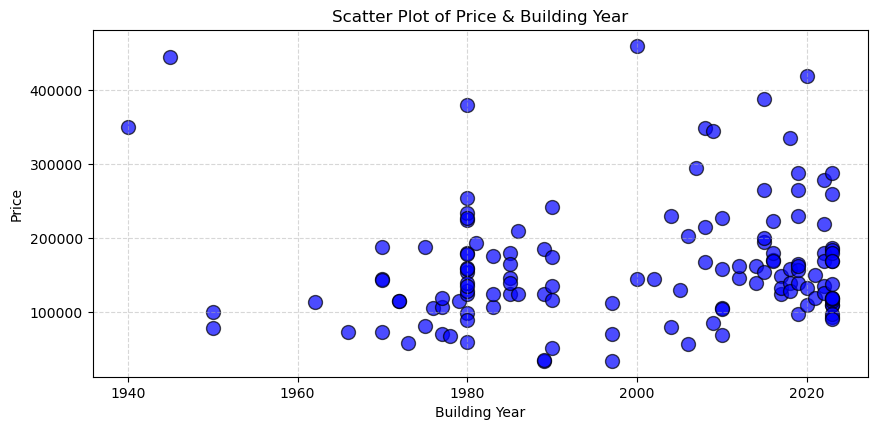

In [644]:
# Filter data
filtered_df = df[df['build_year'] != 0]
filtered_df = filtered_df.sort_values(by='build_year')

plt.figure(figsize=(10, 4.5))
plt.scatter(filtered_df['build_year'], filtered_df['price'], alpha=0.7, s=100, c='blue', edgecolor='black', label='Data Points')
plt.grid(True, linestyle='--', alpha=0.5)
plt.xlabel('Building Year')
plt.ylabel('Price')
plt.title('Scatter Plot of Price & Building Year')
plt.show()

### 5. Insights <a id='5'></a>

**FIN**

Key Insights and Impact:

Through this project, I found out about crucial insights into the real estate landscape. 
   
Some key findings include:

 - Price per Square Meter: The average price per square meter, calculated [here](#average_price_per_meter_calc), visualized [here](#average_price_per_meter_vis), offers a nuanced perspective on property value and market competitiveness.

 - Average Price per Room Analysis: The average apartment price per room, calculated [here](#average_price_per_room_calc) and visualized [here](#average_price_per_room_vis)

 - Neighborhood Dynamics: By visualizing and analyzing popular neighborhoods, gained insights into the distribution of listings and identified areas of high demand, visualized [here](#popular_neighbourhoods_visualized) and calculated [here](#popular_neighbourhoods_calc).

 - Building Year Impact: Understanding the distribution of building years, visualized [here](#build_year_visualized1) and [here](#build_year_visualized2).